In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyIEEM.models.utils import initialize_epinomic_model

In [13]:
country = 'BE'
spatial = True
age_classes = pd.IntervalIndex.from_tuples([(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,120)], closed='left')
simulation_start = '2020-03-01'
model = initialize_epinomic_model(country, age_classes, spatial, simulation_start, contact_type='absolute_contacts')

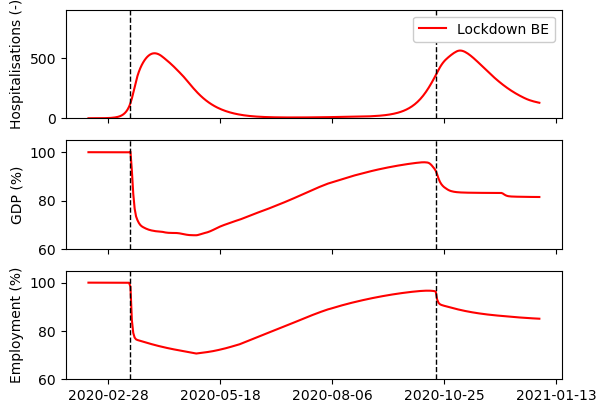

In [34]:
# simulate model
out = model.sim([simulation_start, '2021-01-01'])

fig, ax = plt.subplots(nrows=3, sharex=True)

ax[0].plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='red', label='Lockdown BE')
ax[0].legend(loc=1, framealpha=1)
ax[0].axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax[0].axvline(x=datetime(2020, 10, 19), color='black', linestyle='--', linewidth=1)
ax[0].set_ylabel('Hospitalisations (-)')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[0].set_ylim([-1, 900])

ax[1].plot(out.date, out.x.sum(dim='NACE64')/sum(model.parameters['x_0'])*100, color='red', label='recommendations\nonly')
ax[1].axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax[1].axvline(x=datetime(2020, 10, 19), color='black', linestyle='--', linewidth=1)
ax[1].set_ylabel('GDP (%)')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].set_ylim([60, 105])

ax[2].plot(out.date, out.l.sum(dim='NACE64')/sum(model.parameters['l_0'])*100, color='red', label='recommendations\nonly')
ax[2].axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax[2].axvline(x=datetime(2020, 10, 19), color='black', linestyle='--', linewidth=1)
ax[2].set_ylabel('Employment (%)')
ax[2].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[2].set_ylim([60, 105])

plt.savefig(f'epinomic_{country}.png', dpi=400)
plt.show()
plt.close()